In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
import os 
import pandas as pd
import matplotlib.pyplot as plt
import imageio
from PIL import Image

In [2]:
image_path1 = "dataA/dataA/CameraRGB/"
mask_path1 = "dataA/dataA/CameraSeg/"
image_path2 = "dataB/dataB/CameraRGB/"
mask_path2 = "dataB/dataB/CameraSeg/"

image_list1 =  os.listdir(image_path1)
image_list2 =  os.listdir(image_path2)
image_list1 = [image_path1+ i for i in image_list1]
image_list2 = [image_path2+ i for i in image_list2]

image_list = image_list1 + image_list2

mask_list1 = os.listdir(mask_path1)
mask_list2 = os.listdir(mask_path2)
mask_list1 = [mask_path1 + i for i in mask_list1] 
mask_list2 = [mask_path2 + i for i in mask_list2]               

mask_list = mask_list1 + mask_list2



In [3]:
print(len(image_list))
print(len(mask_list))

2000
2000


Text(0.5, 1.0, 'segmentation')

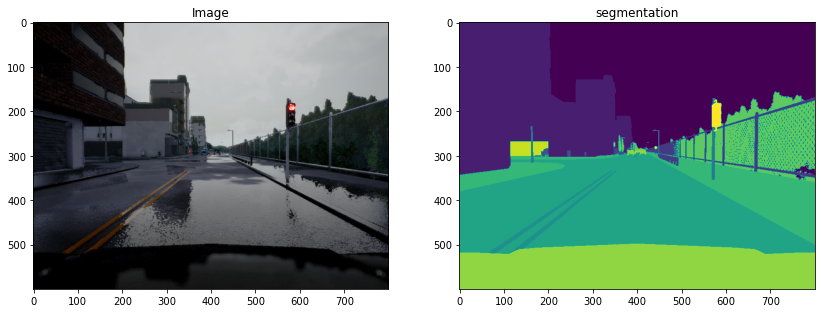

In [4]:
img = imageio.imread(image_list[4])
mask = imageio.imread(mask_list[4])
fig, arr = plt.subplots(1,2, figsize=(14,10))
arr[0].imshow(img)
arr[0].set_title("Image")
arr[1].imshow(mask[:,:,0])
arr[1].set_title("segmentation")

In [5]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle = True)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle = True)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'dataB\\dataB\\CameraRGB\\10_00_193.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'dataB\\dataB\\CameraSeg\\03_01_083.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'dataA\\dataA\\CameraRGB\\F7-60.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'dataB\\dataB\\CameraSeg\\03_01_122.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'dataB\\dataB\\CameraRGB\\F2-62.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'dataA\\dataA\\CameraSeg\\F8-1.png'>)


In [6]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(3):
    print(mask)
    print(image)

tf.Tensor(b'dataA/dataA/CameraSeg/02_00_000.png', shape=(), dtype=string)
tf.Tensor(b'dataA/dataA/CameraRGB/02_00_000.png', shape=(), dtype=string)
tf.Tensor(b'dataA/dataA/CameraSeg/02_00_001.png', shape=(), dtype=string)
tf.Tensor(b'dataA/dataA/CameraRGB/02_00_001.png', shape=(), dtype=string)
tf.Tensor(b'dataA/dataA/CameraSeg/02_00_010.png', shape=(), dtype=string)
tf.Tensor(b'dataA/dataA/CameraRGB/02_00_010.png', shape=(), dtype=string)


In [7]:
def process_path(image_path, mask_path):
    img=tf.io.read_file(image_path)
    img=tf.io.decode_png(img, channels=3)
    img=tf.image.convert_image_dtype(img,tf.float32)
    
    mask=tf.io.read_file(mask_path)
    mask=tf.io.decode_png(mask, channels=3)
    mask=tf.math.reduce_max(mask,axis=-1,keepdims=True)
    return img,mask

def preprocess(img,mask):
    input_image = tf.image.resize(img, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96,128,), method='nearest')
    
    input_image = input_image/255
    return input_image,input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)
    
    
    

In [8]:
def conv_block(inputs = None, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(n_filters,kernel_size=(3,3), activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters,kernel_size=(3,3), activation='relu', padding='same',kernel_initializer='he_normal')(conv)
    
    if(dropout_prob>0):
        conv = Dropout(dropout_prob)(conv)
        
    if(max_pooling):
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
    else:
        next_layer = conv
    
    skip_connection = conv
    
    return next_layer, skip_connection

In [9]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    up = Conv2DTranspose(n_filters, kernel_size=(3,3), strides=2, padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, kernel_size=(3,3), activation='relu',padding='same',kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    
    return conv
    
    

In [10]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    inputs = Input(input_size)
    
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 4*n_filters)    
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob=0.3)    
    cblock5 = conv_block(cblock4[0], 16*n_filters, dropout_prob=0.3, max_pooling=False)
    
    ublock6 = upsampling_block(cblock5[0], cblock4[1], 8*n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1], 4*n_filters)    
    ublock8 = upsampling_block(ublock7, cblock2[1], 2*n_filters)    
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)    

    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock9)
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

In [11]:
unet = unet_model((96, 128, 3))
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 128, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 64, 32)   0           ['conv2d_1[0][0]']           

In [12]:
from PIL import Image
import sys
sys.modules['Image'] = Image
def display(display_list):
    plt.figure(figsize=(15,15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(600, 800, 1)


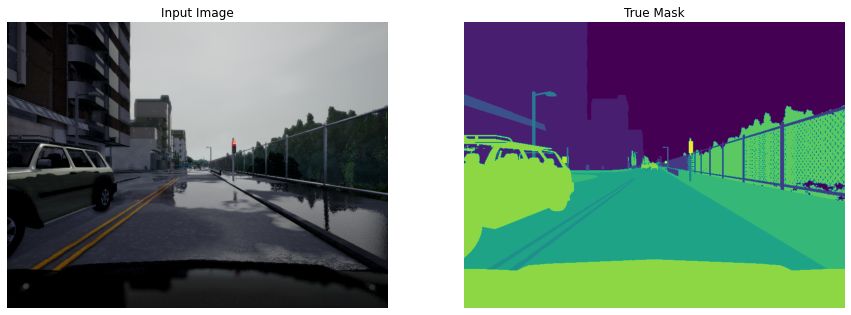

In [69]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [13]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
processed_image_ds.batch(32)
train_dataset = processed_image_ds.cache().shuffle(500).batch(32)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs = 10)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/10
63/63 [==============================] - 165s 1s/step - loss: 1.9313 - accuracy: 0.4141
Epoch 2/10
63/63 [==============================] - 21s 330ms/step - loss: 0.8785 - accuracy: 0.6843
Epoch 3/10
63/63 [==============================] - 21s 331ms/step - loss: 0.6663 - accuracy: 0.7689
Epoch 4/10
63/63 [==============================] - 21s 331ms/step - loss: 0.5743 - accuracy: 0.7930
Epoch 5/10
63/63 [==============================] - 21s 331ms/step - loss: 0.5383 - accuracy: 0.8062
Epoch 6/10
63/63 [==============================] - 21s 332ms/step - loss: 0.5108 - accuracy: 0.8183
Epoch 7/10
63/63 [==============================] - 21s 330ms/step - loss: 0.4651 - accuracy: 0.8421
Epoch 8/10
63/63 [==============================] - 21s 330ms/step - loss: 0.4380 - accuracy: 0.8568
Epoch 9/10
63/63 [==============================] - 21s 334ms/step - loss

In [14]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

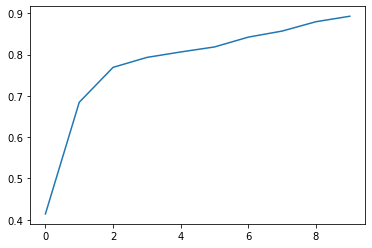

In [15]:
plt.plot(model_history.history["accuracy"])

In [16]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(unet.predict(sample_image[tf.newaxis,...]))])

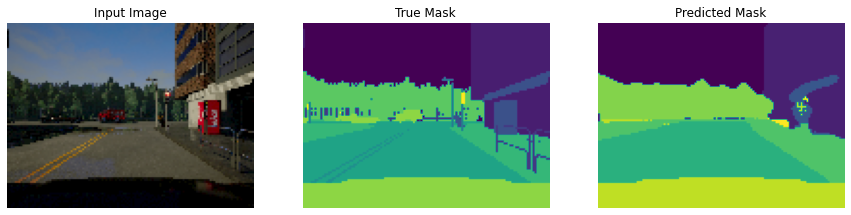

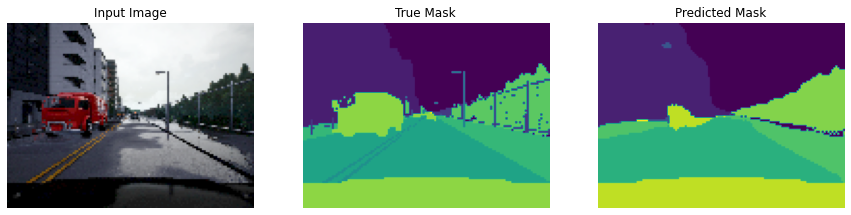

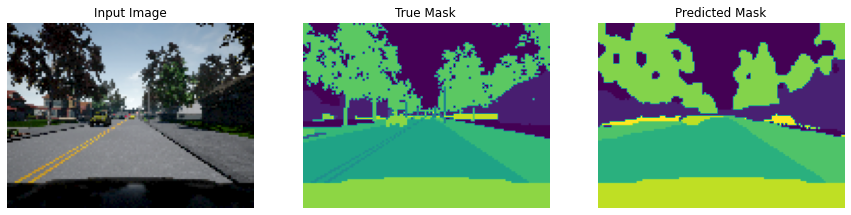

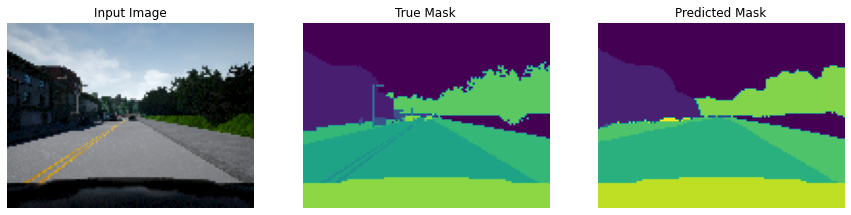

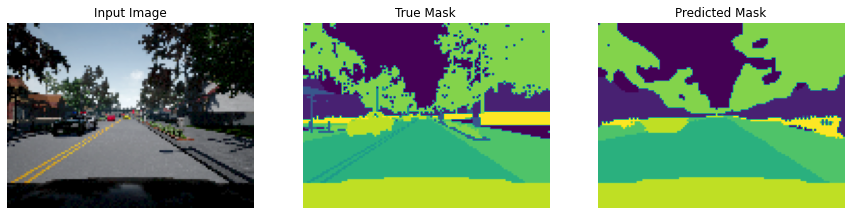

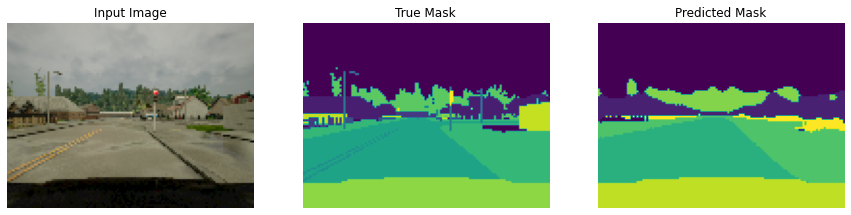

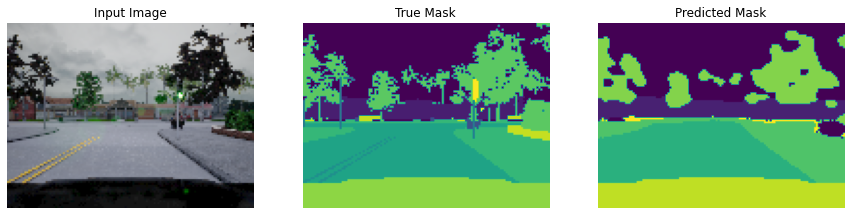

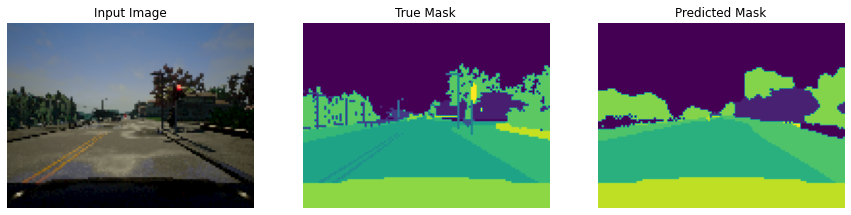

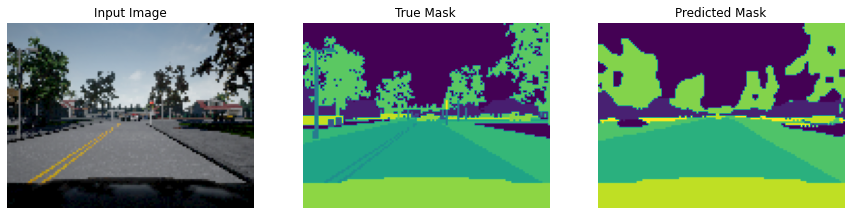

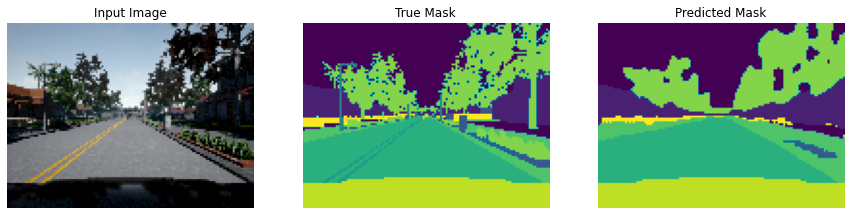

In [17]:
show_predictions(train_dataset, 10)